In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from empiricaldist import Pmf

In [4]:
# Revisiting the euro problem from Ch 4

# How we modeled this before
xs = np.linspace(0, 1, 101)
uniform = Pmf(1, xs)

In [5]:
from scipy.stats import binom

In [6]:
k, n = 140, 250
likelihood = binom.pmf(k, n, xs)

posterior = uniform * likelihood
posterior.normalize()

np.float64(0.3984063745019918)

<Axes: title={'center': 'Posterior distribution of x'}, xlabel='Proportion of heads (x)', ylabel='Probability'>

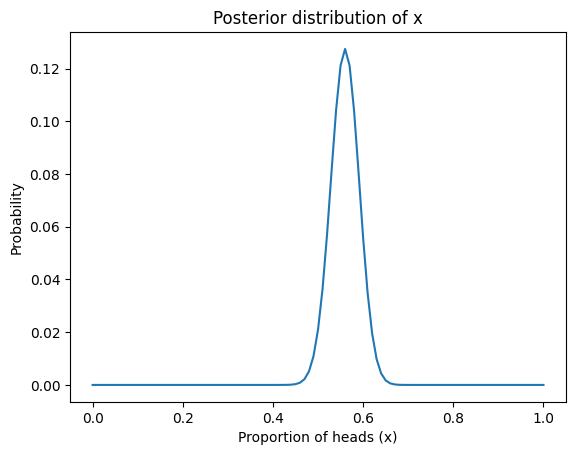

In [7]:
posterior.plot(title="Posterior distribution of x", xlabel="Proportion of heads (x)", ylabel="Probability")

In [8]:
print(posterior.mean(), posterior.credible_interval(0.9))

0.5595238095238095 [0.51 0.61]


In [9]:
# The prior mean is 0.5 and the posterior mean is 0.56, which suggests the coin is biased. BUT ...
# There's the Bayes Factor K = Pr(D|A) / Pr(D|B)
# Consider 2 hypotheses, fair and biased

k = 140
n = 250

like_fair = binom.pmf(k, n, p=0.5)
like_fair # the probability of the data if the coin is fair

np.float64(0.008357181724918188)

In [10]:
# If the coin is biased, the Pr of the data depends on what biased means
# If we define biased beforehand as Pr(H) = 0.56, then ...

like_biased = binom.pmf(k, n, p=0.56)
like_biased

np.float64(0.05077815959518337)

In [11]:
# The Bayes Factor

K = like_biased / like_fair
K # so the data are ~6 times more likely if the coin is biased

np.float64(6.075990838368477)

In [12]:
# But we used the data to define bias; to be honest, we should define bias beforehand
# Suppose "biased" means that Pr(H) =/= 0.5, making all other values equally likely > uniform distribution

biased_uniform = uniform.copy()
biased_uniform[0.5] = 0
biased_uniform.normalize()

np.int64(100)

In [13]:
xs = biased_uniform.qs
likelihood = binom.pmf(k, n, xs)

like_uniform = np.sum(biased_uniform * likelihood) # multiply likelihood by prior probabilities
like_uniform # Pr(D) under "biased uniform" hypothesis

np.float64(0.0039004919277707355)

In [14]:
K = like_fair / like_uniform
K # the data are twice as likely if the coin is fair than if it is biased, by this definition#

np.float64(2.142596851801358)

In [15]:
# How strong is this evidence? Use Bayes Rule

prior_odds = 1
posterior_odds = prior_odds * K
posterior_odds

np.float64(2.142596851801358)

In [16]:
def prob(o):
    return o / (o + 1)

In [17]:
posterior_probability = prob(posterior_odds)
posterior_probability # evidence isn't strong if it moves us from 0.5 to 0.68?

np.float64(0.6817918278551087)

In [18]:
# What if "biased" doesn't mean every value of x is equally likely? We could use a triangular distribution

ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)
a = np.append(ramp_up, ramp_down)

triangle = Pmf(a, xs, name="triangle")
triangle.normalize()

np.int64(2500)

In [19]:
# Then remove Pr(H) = 0.5 as we did with the uniform

biased_triangle = triangle.copy()
biased_triangle[0.5] = 0
biased_triangle.normalize()

np.float64(0.98)

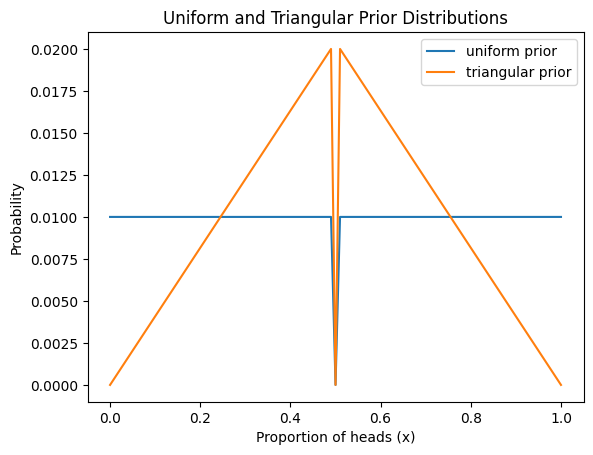

In [21]:
biased_uniform.plot(label="uniform prior", title="Uniform and Triangular Prior Distributions")
biased_triangle.plot(label="triangular prior", xlabel="Proportion of heads (x)", ylabel="Probability")
plt.legend()

In [22]:
# Exercise 10-1

xs = biased_triangle.qs

In [23]:
likelihood2 = binom.pmf(k, n, xs)

like_triangle = np.sum(biased_triangle * likelihood2)
like_triangle

np.float64(0.0069813254648578805)

In [24]:
K2 = like_fair / like_triangle
K2

np.float64(1.1970766535647133)

In [25]:
posterior2_odds = prior_odds * K2
posterior_probability = prob(posterior2_odds)
posterior_probability # not strong evidence, updating prior moves us from 0.5 to 0.54 - but this is correct

np.float64(0.5448497446015277)

In [26]:
# Slot machine analysis

# Say we have 4 slot machines, and a uniform prior about the probability of winning

xs = np.linspace(0, 1, 101)
prior = Pmf(1, xs)
prior.normalize()

beliefs = [prior.copy() for i in range(4)]

In [28]:
# Each time we play a machine, we can use the outcome to update our beliefs

likelihood = {"W": xs, "L": 1 - xs}

In [29]:
def update(pmf, data):
    pmf *= likelihood[data]
    pmf.normalize()

In [30]:
# Suppose we play a machine 10 times, winning once

bandit = prior.copy()

for outcome in "WLLLLLLLLL":
    update(bandit, outcome)

<Axes: title={'center': 'Posterior distribution, 9 losses and 1 win'}, xlabel='Win probability', ylabel='PDF'>

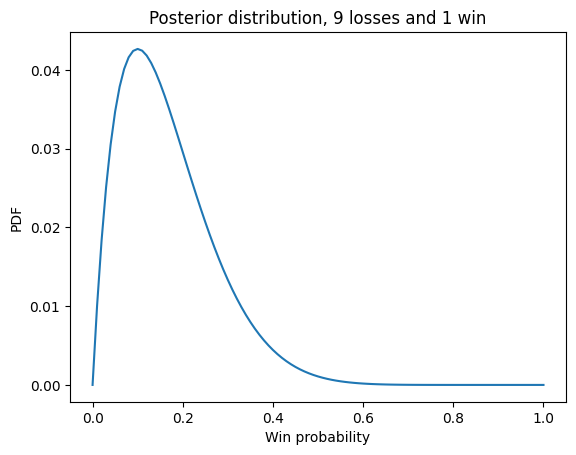

In [31]:
bandit.plot(title="Posterior distribution, 9 losses and 1 win", xlabel="Win probability", ylabel="PDF")

In [32]:
# Suppose there are 4 machines with the following win probabilities

actual_probs = [0.10, 0.20, 0.30, 0.40] # Though we don't know these as the player

In [33]:
from collections import Counter

In [34]:
# Count how many times we've played each machine

counter = Counter()

def play(i):
    """Play machine i. Returns: string 'W' or 'L'"""
    counter[i] += 1
    p = actual_probs[i]
    if np.random.random() < p:
        return 'W'
    else:
        return 'L'

In [35]:
# Play each machine 10 times

for i in range(4):
    for _ in range(10):
        outcome = play(i)
        update(beliefs[i], outcome)

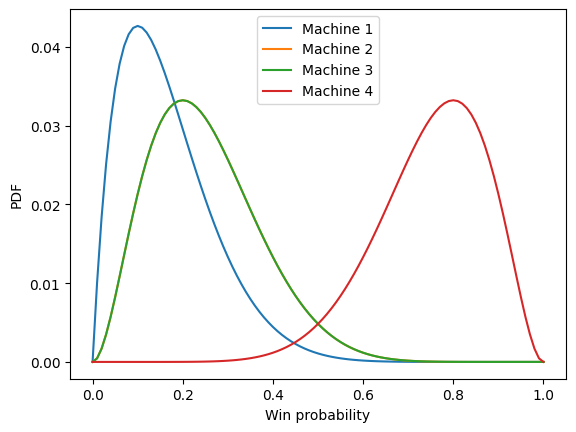

In [38]:
beliefs[0].plot(label="Machine 1")
beliefs[1].plot(label="Machine 2")
beliefs[2].plot(label="Machine 3")
beliefs[3].plot(label="Machine 4", xlabel="Win probability", ylabel="PDF")
plt.legend()

In [39]:
def summarize_beliefs(beliefs):
    columns = ["Actual Pr(win)", "Posterior Mean", "Credible Interval"]
    df = pd.DataFrame(columns=columns)
    for i, b in enumerate(beliefs):
        mean = np.round(b.mean(), 3)
        ci = b.credible_interval(0.9)
        ci = np.round(ci, 3)
        df.loc[i] = actual_probs[i], mean, ci
    return df

In [40]:
summarize_beliefs(beliefs)

,Actual Pr(win),Posterior Mean,Credible Interval
0,0.1,0.167,"[0.03, 0.36]"
1,0.2,0.250,"[0.08, 0.47]"
2,0.3,0.250,"[0.08, 0.47]"
3,0.4,0.750,"[0.53, 0.92]"


In [41]:
# An optimal strategy for choosing a machine to play i sbased on Thompson sampling, 
# where a random choice of machine is chosen by a probability proportional to the probability that it's best

samples = np.array([b.choice(1000) for b in beliefs])
samples.shape

(4, 1000)

In [42]:
indices = np.argmax(samples, axis=0) # find the index of the largest value in each column
indices.shape

(1000,)

In [43]:
# Pmf of these indices is the % of times each machine yielded the highest values

pmf = Pmf.from_seq(indices)
pmf

,probs
0,0.003
1,0.007
2,0.003
3,0.987


In [44]:
pmf.choice()

array([3])

In [45]:
# But there's a shortcut to this - drawing a single random value from each posterior and pick the machine with 
# the highest value, yields a choice of machine in proportion to its prob of superiority

def choose(beliefs):
    ps = [b.choice() for b in beliefs]
    return np.argmax(ps)

In [46]:
choose(beliefs)

np.int64(3)

In [47]:
# Bringing this together, this function chooses a machine, plays once, and updates beliefs

def choose_play_update(beliefs):
    machine = choose(beliefs)
    outcome = play(machine)
    update(beliefs[machine], outcome)

In [48]:
# Test this by starting with a fresh set of beliefs and an empty Counter

beliefs = [prior.copy() for i in range(4)]
counter = Counter()

In [49]:
num_plays = 100

for i in range(num_plays):
    choose_play_update(beliefs)

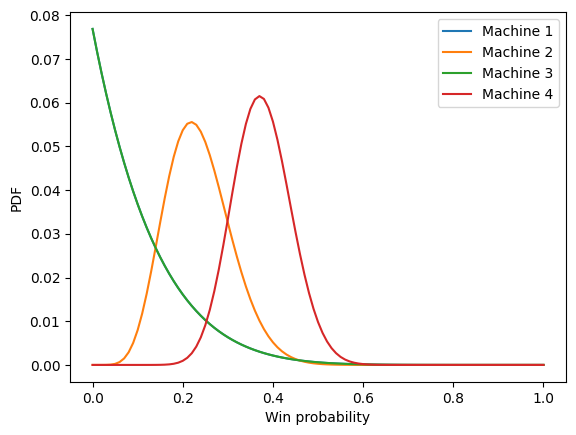

In [50]:
beliefs[0].plot(label="Machine 1")
beliefs[1].plot(label="Machine 2")
beliefs[2].plot(label="Machine 3")
beliefs[3].plot(label="Machine 4", xlabel="Win probability", ylabel="PDF")
plt.legend()

In [51]:
summarize_beliefs(beliefs)

,Actual Pr(win),Posterior Mean,Credible Interval
0,0.1,0.107,"[0.0, 0.31]"
1,0.2,0.235,"[0.13, 0.36]"
2,0.3,0.107,"[0.0, 0.31]"
3,0.4,0.375,"[0.27, 0.48]"


In [53]:
def summarize_counter(counter):
    index = range(4)
    columns = ["Actual Pr(win)", "Times Played"]
    df = pd.DataFrame(index=index, columns=columns)
    for i, count in counter.items():
        df.loc[i] = actual_probs[i], count
    return df

In [54]:
summarize_counter(counter)

,Actual Pr(win),Times Played
0,0.1,7
1,0.2,32
2,0.3,7
3,0.4,54


In [ ]:
# Exercise 10-2 - adaptive SAT testing